In [38]:
# Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
from io import StringIO

In [242]:
#Set the fiat currency pair
from_symbol = "GBP"
to_symbol = "CAD"
interval = "60min"
api_key = "CV4O3KUIMS9TVCLR"

In [243]:
# Load the data from the API
url = f"https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol={from_symbol}&to_symbol={to_symbol}&interval={interval}&apikey={api_key}&datatype=csv"
request = requests.get(url)

In [244]:
#Convert the CSV to a pandas dataframe
data = StringIO(request.text)
csv_res_df = pd.read_csv(data)

In [245]:
# Convert to DataFrame
data_df = csv_res_df.copy()
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
pricing_df = data_df.set_index('timestamp')
pricing_df.sort_index(ascending=True, inplace=True)

In [246]:
# Declare the variables that will be used globally as SMA window, Short Period and Long Period / Standard Deviation
# length / short period - The SMA window
# std / long period - The standard deviation

sma_window = 20
std = 2

In [247]:
pricing_df.ta.bbands(close = 'close', std = std, length = sma_window, append = True)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
timestamp,,,,,
2023-10-02 13:00:00,NaN,NaN,NaN,NaN,NaN
2023-10-02 14:00:00,NaN,NaN,NaN,NaN,NaN
2023-10-02 15:00:00,NaN,NaN,NaN,NaN,NaN
2023-10-02 16:00:00,NaN,NaN,NaN,NaN,NaN
2023-10-02 17:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-06 12:00:00,1.668277,1.671241,1.674205,0.354692,1.157754
2023-10-06 13:00:00,1.665968,1.670787,1.675606,0.576796,-0.359912
2023-10-06 14:00:00,1.665402,1.670577,1.675752,0.619575,0.102240


In [248]:
#Create f strings for the column names
str_upper_band = f"BBU_{sma_window}_{std}.0"
str_middle_band = f"BBM_{sma_window}_{std}.0"
str_lower_band = f"BBL_{sma_window}_{std}.0"

# Generate the trading signals
# 1 Represents a buy
# -1 represents a sell
# 0 represents a hold
bands_signal = []
signal = 0

for i in range(len(pricing_df['close'])):
    # Today's price is below the lower band
    # The price has dropped below the bands and a rise is expected
    # We want to buy
    #print("Close : "+str(pricing_df['close'][i]))
    #print("Lower : "+str(pricing_df[str_lower_band][i]))
    #print("Upper : "+str(pricing_df[str_upper_band][i]))
    
    if pricing_df['close'][i] < pricing_df[str_lower_band][i]:
        # If we are not already in a buy position
        # Add today's price to the buy list
        # Update the signal to show we are in buy
        signal = 1
        bands_signal.append(signal)

    # Today's price is above the upper band
    # The price has increased above the bands and a drop is expected
    # We want to sell
    elif pricing_df['close'][i] > pricing_df[str_upper_band][i]:

        # If we are not already in a sell position
        # Add today's price to the sell list
        # Update the signal to show we are in sell
        signal = -1
        bands_signal.append(signal)
    else:
        signal = 0
        bands_signal.append(signal)
        
#Create positions for our strategy
position = []
for i in range(len(bands_signal)):
    if bands_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(len(pricing_df['close'])):
    # If we are in a buy position, set our position as buy
    if bands_signal[i] == 1:
        position[i] = 1
    # If we are in a sell position, set our position as sell
    elif bands_signal[i] == -1:
        position[i] = 0
    # Otherwise use yesterday's position
    else:
        position[i] = position[i-1]

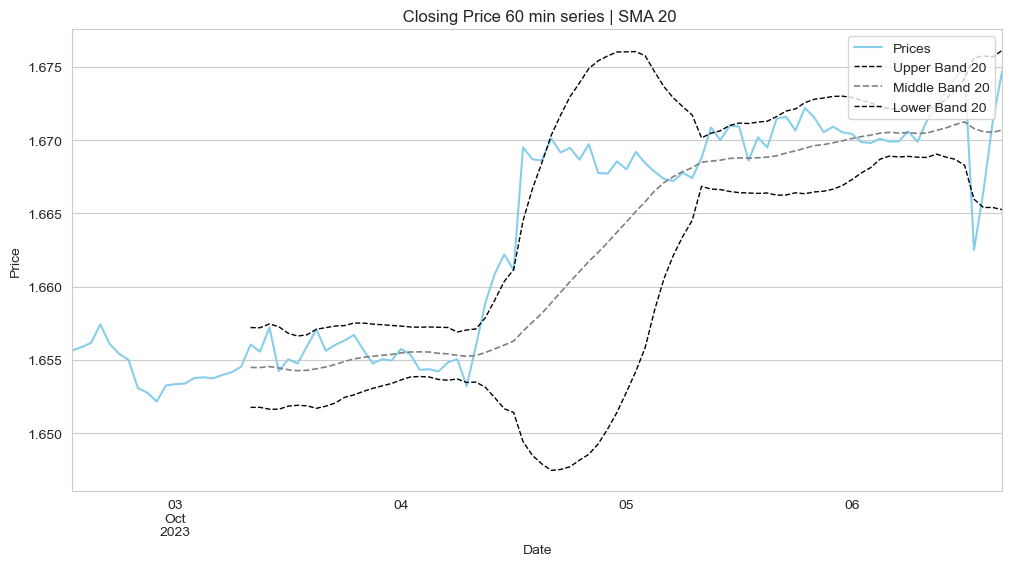

In [249]:
plt.figure(figsize = (12,6))
plt.title(" Closing Price 60 min series | SMA "+str(sma_window))
pricing_df['close'].plot(label = 'Prices', color = 'skyblue')
pricing_df[str_upper_band].plot(label = 'Upper Band '+str(sma_window), linestyle = '--', linewidth = 1, color = 'black')
pricing_df[str_middle_band].plot(label = 'Middle Band '+str(sma_window), linestyle = '--', linewidth = 1.2, color = 'grey')
pricing_df[str_lower_band].plot(label = 'Lower Band '+str(sma_window), linestyle = '--', linewidth = 1, color = 'black')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

In [250]:
count_neg = 0
count_pos = 0
count_zel = 0

for i in bands_signal:
    if i == -1:
        count_neg+= 1
    elif i == 1:
        count_pos+=1
    else:
        count_zel+=1
        
print(count_neg)
print(count_pos)
print(count_zel)

11
2
87


In [254]:
#Create a copy of the main dataset
main_df_new = pricing_df.copy()

#Add the bands_signal list to the main dataset
main_df_new['Signal'] = bands_signal

#Add the positions list to the main dataset
main_df_new['Position'] = position

#Calculate Returns and Cummulative Returns and append to the DataFrame
#New column name is LOGRET_1
main_df_new.ta.log_return(close='close', append=True)

#New column name is CUMLOGRET_1
main_df_new.ta.log_return(close='close',cumulative=True, append=True)

main_df_new.tail()

,open,high,low,close,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,Signal,Position,LOGRET_1,CUMLOGRET_1
timestamp,,,,,,,,,,,,,
2023-10-06 12:00:00,1.67426,1.67520,1.67314,1.67514,1.668277,1.671241,1.674205,0.354692,1.157754,-1,0,0.000567,0.011709
2023-10-06 13:00:00,1.67504,1.67620,1.66058,1.66250,1.665968,1.670787,1.675606,0.576796,-0.359912,1,1,-0.007574,0.004135
2023-10-06 14:00:00,1.66251,1.66655,1.66232,1.66646,1.665402,1.670577,1.675752,0.619575,0.102240,0,1,0.002379,0.006514
2023-10-06 15:00:00,1.66655,1.67394,1.66645,1.67125,1.665397,1.670530,1.675663,0.614498,0.570139,0,1,0.002870,0.009384
2023-10-06 16:00:00,1.67125,1.67494,1.67123,1.67472,1.665253,1.670689,1.676125,0.650755,0.870766,0,1,0.002074,0.011458


In [252]:
#Calculate the performance on the strategy data
main_df_new['Strategy'] = main_df_new['Position'] * main_df_new['LOGRET_1']
main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum()

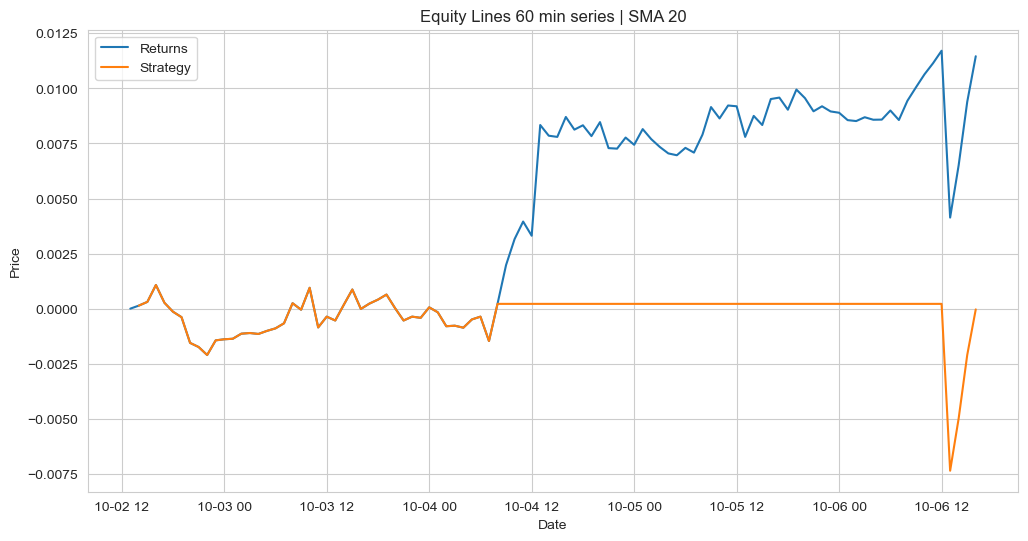

In [253]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("Equity Lines 60 min series | SMA "+str(sma_window))
plt.plot(main_df_new['CUMLOGRET_1'], label = "Returns")
plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
plt.xlabel("Date")
plt.ylabel("Price")
sns.set_style("whitegrid")
plt.legend(loc='upper left')
plt.show()